In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.3 MB/s eta 0:00:00


In [ ]:
!pip install ale-py
!pip install autorom[accept-rom-license]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=92d9f2e686ca3bf59dfe0edb04ff7d1dc3ccfd971ad2059c47edbfa6ba8198df
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [ ]:
import numpy as np
probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]

print(expected_value)

18.4


In [ ]:
expected_value = probs @ outcomes
print(expected_value)

18.4


In [ ]:
t0 = 18.4
T = lambda: t0 + np.random.randn(1)
T()

array([17.95607589])

<BarContainer object of 51 artists>

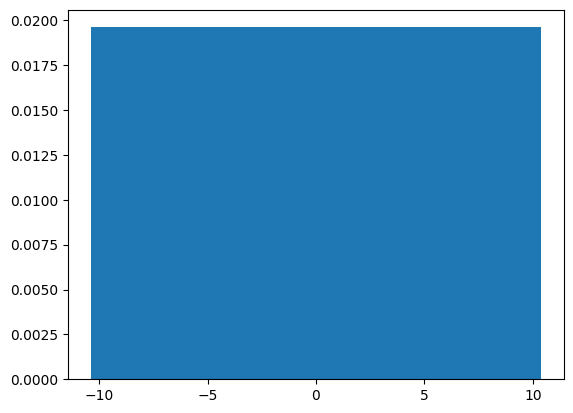

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt

vmin,vmax = -10.,10.
nsup=51
support = np.linspace(vmin,vmax,nsup)
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support,probs)

In [ ]:
def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    bj = np.round((r-vmin)/dz)
    bj = int(np.clip(bj,0,nsup-1))
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1):
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1):
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum()
    return m

In [ ]:
probs

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

<BarContainer object of 51 artists>

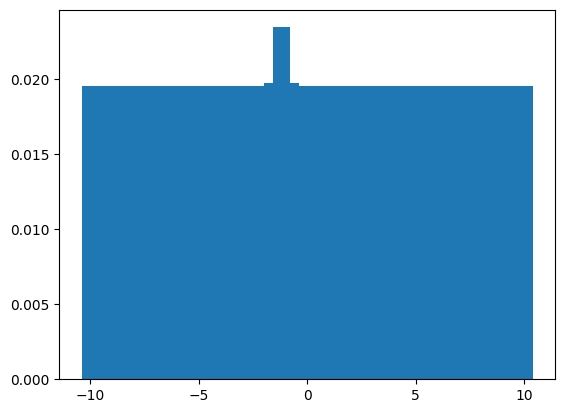

In [ ]:
ob_reward = -1
Z = torch.from_numpy(probs).float()
Z = update_dist(ob_reward,torch.from_numpy(support).float(),Z,lim=(vmin,vmax),gamma=0.1)
plt.bar(support,Z)

<BarContainer object of 51 artists>

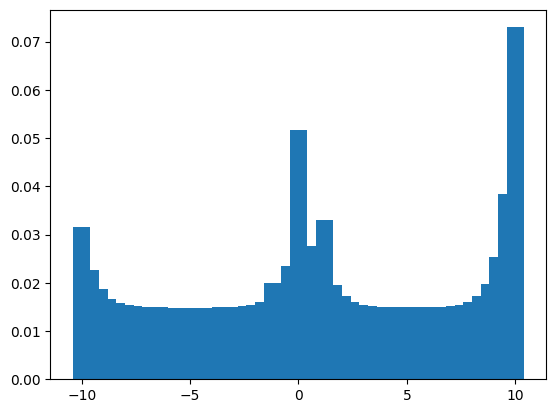

In [ ]:
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin,vmax), gamma=0.5)
plt.bar(support, Z)

<BarContainer object of 51 artists>

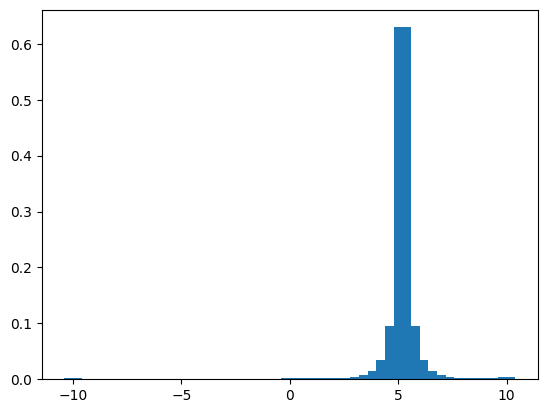

In [ ]:
ob_rewards = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), \
    Z, lim=(vmin,vmax), gamma=0.7)
plt.bar(support, Z)

In [ ]:
def dist_dqn(x,theta,aspace=3):
    dim0,dim1,dim2,dim3 = 128,100,25,51
    t1 = dim0*dim1
    t2 = dim2*dim1
    theta1 = theta[0:t1].reshape(dim0,dim1)
    theta2 = theta[t1:t1 + t2].reshape(dim1,dim2)
    l1 = x @ theta1 #D
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 #E
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace):
        step = dim2*dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2,dim3)
        l3_ = l2 @ theta5
        l3.append(l3_)
    l3 = torch.stack(l3,dim=1)
    l3 = torch.nn.functional.softmax(l3,dim=2)
    return l3.squeeze()

In [ ]:
def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1:
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else:
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist

    return target_dist_batch

In [ ]:
def lossfn(x,y):#A
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]):
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss

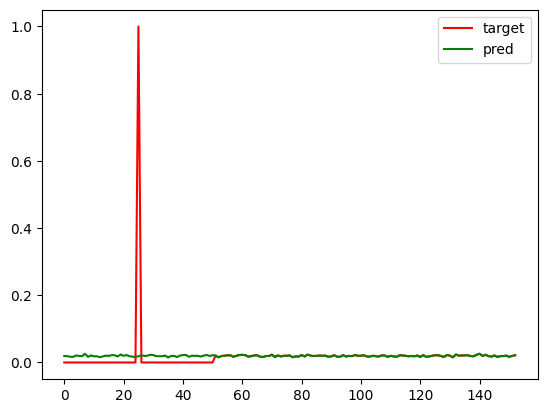

In [ ]:
aspace = 3 #A
tot_params = 128*100 + 25*100 + aspace*25*51
theta = torch.randn(tot_params)/10.
theta.requires_grad=True
theta_2 = theta.detach().clone()

vmin,vmax= -10,10
gamma=0.9
lr = 0.00001
update_rate = 75
support = torch.linspace(-10,10,51)
state = torch.randn(2,128)/10.
action_batch = torch.Tensor([0,2])
reward_batch = torch.Tensor([0,10])
losses = []
pred_batch = dist_dqn(state,theta,aspace=aspace)
target_dist = get_target_dist(pred_batch,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma)

plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.legend()

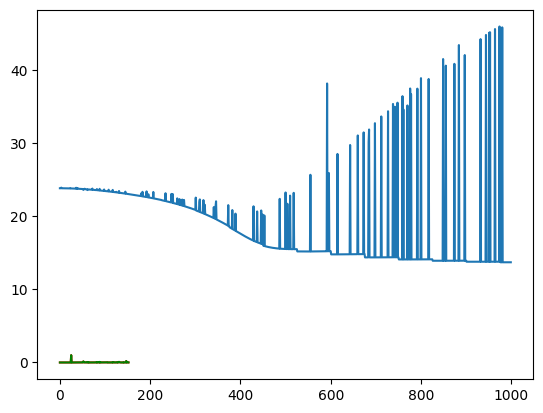

In [ ]:
for i in range(1000):
    reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0
    pred_batch = dist_dqn(state,theta,aspace=aspace)
    pred_batch2 = dist_dqn(state,theta_2,aspace=aspace)
    target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma)
    loss = lossfn(pred_batch,target_dist.detach())
    losses.append(loss.item())
    loss.backward()

    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True

    if i % update_rate == 0:
        theta_2 = theta.detach().clone()

plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.plot(losses)

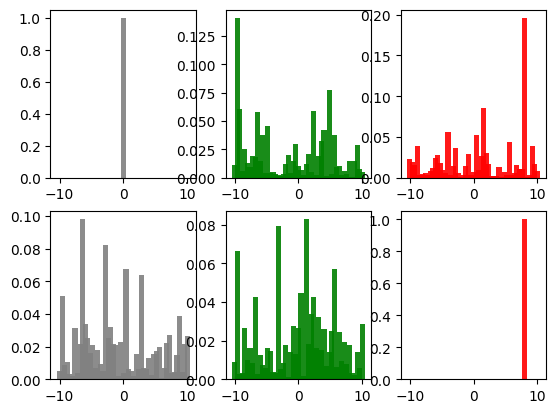

In [ ]:
tpred = pred_batch
cs = ['gray','green','red']
num_batch = 2
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig,ax = plt.subplots(nrows=num_batch,ncols=aspace)

for j in range(num_batch):
    for i in range(tpred.shape[1]):
        ax[j,i].bar(support.data.numpy(),tpred[j,i,:].data.numpy(),\
                label='Action {}'.format(i),alpha=0.9,color=cs[i])

In [ ]:
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1)
    return p_state

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]):
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [ ]:
import gymnasium as gym
import ale_py
from collections import deque
env = gym.make('ALE/Freeway-ram-v5')
aspace = 3
env.unwrapped.get_action_meanings()


vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size)
lr = 0.0001
gamma = 0.1
epochs = 1300
eps = 0.20
eps_min = 0.05
priority_level = 5
update_freq = 25


tot_params = 128*100 + 25*100 + aspace*25*51
theta = torch.randn(tot_params)/10.
theta.requires_grad=True
theta_2 = theta.detach().clone()

losses = []
cum_rewards = []
renders = []
state = preproc_state(env.reset()[0])

In [ ]:
from random import shuffle
for i in range(epochs):
    pred = dist_dqn(state,theta,aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(),support).item()
    state2, reward, done, info, _ = env.step(action)
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1)
    reward = 10 if reward == 1 else reward
    reward = -10 if done else reward
    reward = -1 if reward == 0 else reward
    exp = (state,action,reward,state2)
    replay.append(exp)

    if reward == 10:
        for e in range(priority_level):
            replay.append(exp)

    shuffle(replay)
    state = state2

    if len(replay) == replay_size:
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach(),theta,aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(),theta_2,aspace=aspace)
        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, \
                                     support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True

    if i % update_freq == 0:
        theta_2 = theta.detach().clone()

    if i > 100 and eps > eps_min:
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec

    if done:
        state = preproc_state(env.reset())
        done = False

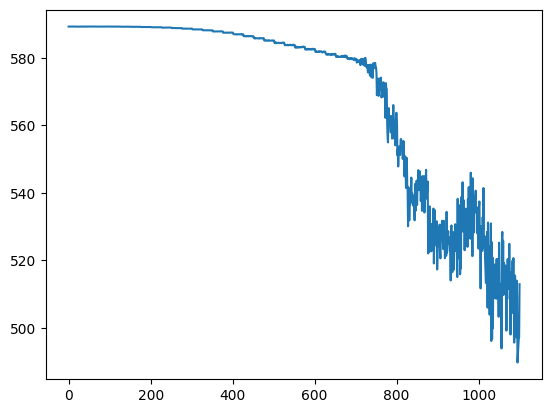

In [ ]:
plt.plot(losses)